# AB Testing with Machine Learning

Problem Statement

Experiment Name: “Free Trial” Screener

* In the experiment, Udacity tested a change where if the student clicked “start free trial”, they were asked how much time they had available to devote to the course.

* If the student indicated 5 or more hours per week, they would be taken through the checkout process as usual. If they indicated fewer than 5 hours per week, a message would appear indicating that Udacity courses usually require a greater time commitment for successful completion.

* The goal was to set clear expectations upfront, reducing the number leaving the free trial because they didn’t have enough time.

* They did not want to “significantly” reduce the number of students that continue past the free trial and eventually complete the course.

* In this notebook we will investigate whether we can predict an enrolments based on the number of clicks, page views, payments and whether they are in the control group or treatment group - what causes people to enrol in a course?

* The notebook is adapted from [AB Testing with Machine Learning in R](https://www.business-science.io/business/2019/03/11/ab-testing-machine-learning.html)

* Please note the word enrolments (English spelling) is spelt this way or the American way enrollments interchangeably throughout the notebook

## Import Libraries and Data

In [923]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from dython.nominal import associations

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [ ]:
sklearn.metrics import 

In [472]:
df_control = pd.read_csv("C:/Users/imoge/Projects/Datasets/enrol_control_data.csv", index_col=False)
df_exp = pd.read_csv("C:/Users/imoge/Projects/Datasets/enrol_experiment_data.csv")

Dataset:

* Date: a character formatted Day, Month, and Day of Month
* Pageviews: An aggregated count of Page Views on the given day
* Clicks: An aggregated count of Page Clicks on the given day for the page in question
* Enrolments: An aggregated count of Enrolments by day.
* Payments: An aggregated count of Payments by day.

## Data Preparation

In [473]:
df_control.shape, df_exp.shape

((37, 5), (37, 5))

In [474]:
df_control.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.00,70.00
1,"Sun, Oct 12",9102,779,147.00,70.00
2,"Mon, Oct 13",10511,909,167.00,95.00
3,"Tue, Oct 14",9871,836,156.00,105.00
4,"Wed, Oct 15",10014,837,163.00,64.00


In [475]:
df_control.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         37 non-null     object 
 1   Pageviews    37 non-null     int64  
 2   Clicks       37 non-null     int64  
 3   Enrollments  23 non-null     float64
 4   Payments     23 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.6+ KB


In [476]:
df_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         37 non-null     object 
 1   Pageviews    37 non-null     int64  
 2   Clicks       37 non-null     int64  
 3   Enrollments  23 non-null     float64
 4   Payments     23 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.6+ KB


We have some missing data

In [477]:
df_control.isnull().sum()

Date            0
Pageviews       0
Clicks          0
Enrollments    14
Payments       14
dtype: int64

In [478]:
df_exp.isnull().sum()

Date            0
Pageviews       0
Clicks          0
Enrollments    14
Payments       14
dtype: int64

In [479]:
# Find rows with missing values in training set
df_control[df_control.isna().any(axis=1)]

,Date,Pageviews,Clicks,Enrollments,Payments
23,"Mon, Nov 3",9437,788,NaN,NaN
24,"Tue, Nov 4",9420,781,NaN,NaN
25,"Wed, Nov 5",9570,805,NaN,NaN
26,"Thu, Nov 6",9921,830,NaN,NaN
27,"Fri, Nov 7",9424,781,NaN,NaN
28,"Sat, Nov 8",9010,756,NaN,NaN
29,"Sun, Nov 9",9656,825,NaN,NaN
30,"Mon, Nov 10",10419,874,NaN,NaN
31,"Tue, Nov 11",9880,830,NaN,NaN
32,"Wed, Nov 12",10134,801,NaN,NaN


In [480]:
# Find rows with missing values in test set
df_exp[df_exp.isna().any(axis=1)]

,Date,Pageviews,Clicks,Enrollments,Payments
23,"Mon, Nov 3",9359,789,NaN,NaN
24,"Tue, Nov 4",9427,743,NaN,NaN
25,"Wed, Nov 5",9633,808,NaN,NaN
26,"Thu, Nov 6",9842,831,NaN,NaN
27,"Fri, Nov 7",9272,767,NaN,NaN
28,"Sat, Nov 8",8969,760,NaN,NaN
29,"Sun, Nov 9",9697,850,NaN,NaN
30,"Mon, Nov 10",10445,851,NaN,NaN
31,"Tue, Nov 11",9931,831,NaN,NaN
32,"Wed, Nov 12",10042,802,NaN,NaN


* These all seem to be related to November. 
* We will drop these rows

In [481]:
df_control.dropna(inplace = True)
df_exp.dropna(inplace = True)

In [482]:
df_control.shape, df_exp.shape

((23, 5), (23, 5))

In [483]:
df_control.head(1)

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.00,70.00


In [484]:
df_control.tail(1)

,Date,Pageviews,Clicks,Enrollments,Payments
22,"Sun, Nov 2",8836,693,206.00,67.00


* Our date range is basically for October so we can really only extract information about the day of the week to use in this model
* The days consist of three characters so we extract these

In [485]:
df_control["DayofWeek"] = df_control["Date"].str[:3]
df_control.head()

,Date,Pageviews,Clicks,Enrollments,Payments,DayofWeek
0,"Sat, Oct 11",7723,687,134.00,70.00,Sat
1,"Sun, Oct 12",9102,779,147.00,70.00,Sun
2,"Mon, Oct 13",10511,909,167.00,95.00,Mon
3,"Tue, Oct 14",9871,836,156.00,105.00,Tue
4,"Wed, Oct 15",10014,837,163.00,64.00,Wed


In [486]:
df_exp["DayofWeek"] = df_exp["Date"].str[:3]

In [487]:
df_exp.head()

,Date,Pageviews,Clicks,Enrollments,Payments,DayofWeek
0,"Sat, Oct 11",7716,686,105.00,34.00,Sat
1,"Sun, Oct 12",9288,785,116.00,91.00,Sun
2,"Mon, Oct 13",10480,884,145.00,79.00,Mon
3,"Tue, Oct 14",9867,827,138.00,92.00,Tue
4,"Wed, Oct 15",9793,832,140.00,94.00,Wed


In [488]:
#Drop columns not needed
df_control.drop(columns = ["Date"], axis = 1, inplace = True)
df_exp.drop(columns = ['Date'], axis = 1, inplace = True)

In [489]:
# Look at basic stats - control group
df_control.describe().T

,count,mean,std,min,25%,50%,75%,max
Pageviews,23.00,9224.48,850.30,7434.00,8761.50,9327.00,9770.50,10667.00
Clicks,23.00,751.87,77.01,632.00,691.00,736.00,829.50,909.00
Enrollments,23.00,164.57,29.98,110.00,146.50,162.00,175.00,233.00
Payments,23.00,88.39,20.65,56.00,70.00,91.00,102.50,128.00


In [490]:
# Basic stats for experiment group
df_exp.describe().T

,count,mean,std,min,25%,50%,75%,max
Pageviews,23.00,9189.65,802.03,7664.00,8692.00,9288.00,9696.00,10551.00
Clicks,23.00,750.43,70.32,642.00,696.00,728.00,794.50,884.00
Enrollments,23.00,148.83,33.23,94.00,127.00,142.00,172.00,213.00
Payments,23.00,84.57,23.06,34.00,69.00,91.00,99.00,123.00


* The mean enrollments and payments for the experiment group is less than the control

In [492]:
# Convert both enrollments and payments to integers as they are not floats
df_control['Enrollments'] = df_control['Enrollments'].astype(int)
df_control['Payments'] = df_control['Payments'].astype(int)
df_exp['Enrollments'] = df_exp['Enrollments'].astype(int)
df_exp['Payments'] = df_exp['Payments'].astype(int)

## Hypothesis Test

* We will first find out if there is a difference in enrollments between the control and treatment group
* This will be in the form of an AB test
* H0: There is no difference between the mean enrollment of control or treatment group
* H1: There is a difference between the mean enrollment of the control or treatment group
* We have 23 rows in each of the groups so we shouldn't use a t-test

In [801]:
df_combined["Ind"].value_counts()

1    23
0    23
Name: Ind, dtype: int64

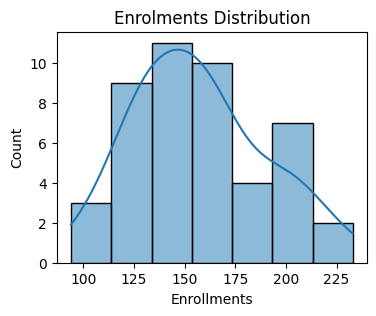

In [835]:
# Plot distribution of birth weights
fig, ax = plt.subplots(figsize = (4,3))
sns.histplot(data=df_combined,x=df_combined["Enrollments"], kde = True)
plt.title("Enrolments Distribution");

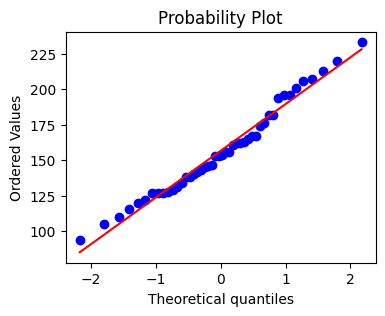

In [808]:
# Check with qq plot
fig, ax = plt.subplots(figsize = (4,3))
stats.probplot(df_combined["Enrollments"], dist = "norm", plot = plt);

In [809]:
# Shapiro test of normality
stats.shapiro(df_combined["Enrollments"])

ShapiroResult(statistic=0.9760396480560303, pvalue=0.45435917377471924)

* The two charts and shapiro test indicate that the data is normally distributed. 
* T- tests do not require it but useful to understand the data

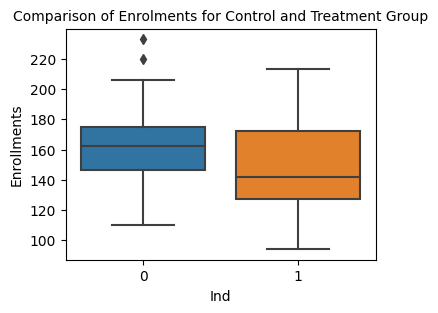

In [836]:
fig, ax = plt.subplots(figsize = (4,3))
sns.boxplot(data = df_combined, x = "Ind", y = "Enrollments")
plt.title("Comparison of Enrolments for Control and Treatment Group", fontsize = 10);

In [812]:
# Get the means of each and compare
print(df_control["Enrollments"].mean())
print(df_exp["Enrollments"].mean())

164.56521739130434
148.82608695652175


* The means of the two groups, together with the boxplot suggests that there is a difference between control and treatment groups but is it significant?

In [814]:
# F-test for equality of variances
stats.f_oneway(df_control["Enrollments"],df_exp["Enrollments"])

F_onewayResult(statistic=2.844325000542627, pvalue=0.09877614030153417)

In [813]:
# Are the variances equal?
stats.levene(df_control["Enrollments"], df_exp["Enrollments"])

LeveneResult(statistic=0.36830501645593133, pvalue=0.5470486201120376)

* We fail to reject the null hypothesis of equal variance so we can run the 2 sample independent t-test

In [817]:
# Independent 2 sample t-test
stats.ttest_ind(df_control["Enrollments"], df_exp["Enrollments"])

Ttest_indResult(statistic=1.686512674290538, pvalue=0.09877614030153456)

* The p-value which is the probability that a difference between means is due to chance is above the 5% significance level, so we fail to reject the Null Hypothesis of sample means being the same. 
* We can say that enrolments of the treatment group are not significantly different from that of the control group.
* We will see if we can build a predictive model to predict whether we get a payment based on the features of enrolments, clicks, pageviews and whether or not they are shown the popup button.

## Exploratory Data Analysis

### Enrollments

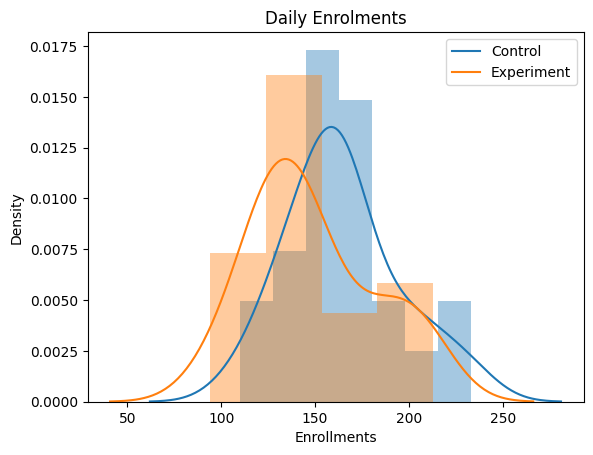

In [837]:
sns.distplot(df_control['Enrollments'])
sns.distplot(df_exp['Enrollments'])
plt.title('Daily Enrolments')
plt.legend(labels=['Control','Experiment']);

In [494]:
print(df_control['Enrollments'].skew())
print(df_exp['Enrollments'].skew())

0.5758077705678025
0.54663405782461


* Enrolments in the treatment group are lower than the control group
* This is perhaps what we might expect given the message given to those who can commit less than 5 hours per week

### Page Views

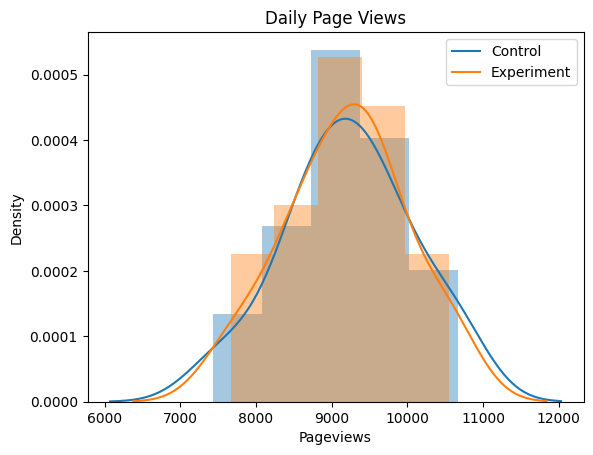

In [495]:
sns.distplot(df_control['Pageviews'])
sns.distplot(df_exp['Pageviews'])
plt.title('Daily Page Views')
plt.legend(labels=['Control','Experiment']);

In [496]:
print(df_control['Pageviews'].skew())
print(df_exp['Pageviews'].skew())

-0.13663202451334866
-0.1165679366343369


* Daily page views are broadly similar between the two groups

In [497]:
# Plot the distribution between the two groups
#fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,3))
#fig.suptitle('Daily Page Views')
#ax1.hist(df_control['Pageviews'], ec = 'k')
#ax2.hist(df_exp['Pageviews'], ec = 'k')
#ax1.set_title("Control Group")
#ax2.set_title("Experiment Group")
#ax1.set_xlabel("Num.Views")
#ax2.set_xlabel("Num.Views");

### Clicks

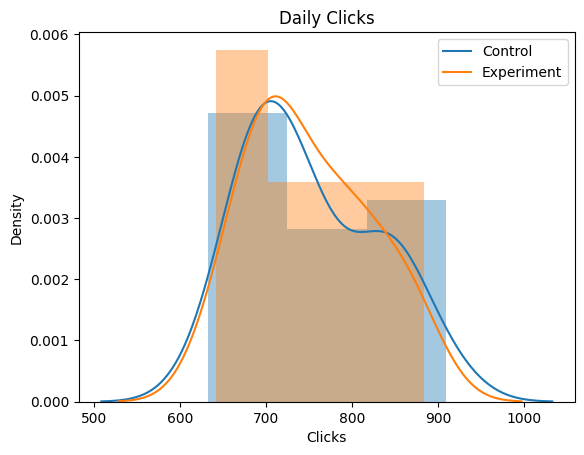

In [498]:
sns.distplot(df_control['Clicks'])
sns.distplot(df_exp['Clicks'])
plt.title('Daily Clicks')
plt.legend(labels=['Control','Experiment']);

In [499]:
print(df_control['Clicks'].skew())
print(df_exp['Clicks'].skew())

0.5005292895549792
0.3782586337248761


* The spread for both groups is fairly similar

### Payments

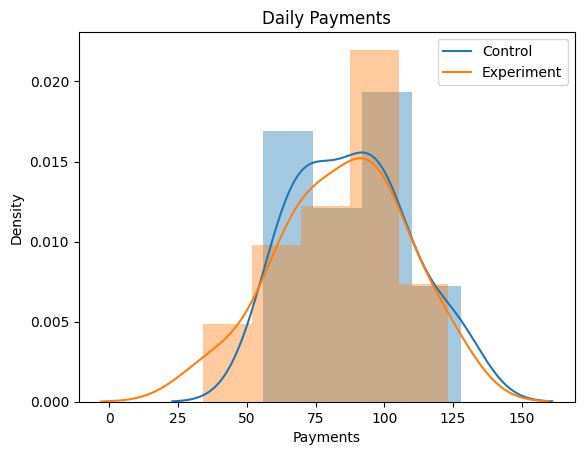

In [500]:
sns.distplot(df_control['Payments'])
sns.distplot(df_exp['Payments'])
plt.title('Daily Payments')
plt.legend(labels=['Control','Experiment']);

In [501]:
print(df_control['Payments'].skew())
print(df_exp['Payments'].skew())

0.32169546746538535
-0.300628838834334


### Day of Week

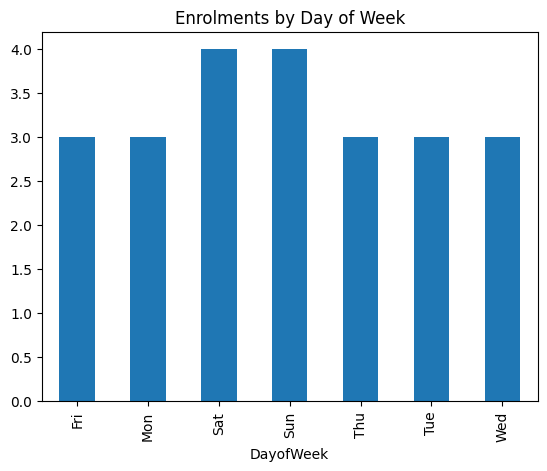

In [838]:
df_control.groupby('DayofWeek')['Enrollments'].count().plot(kind = 'bar')
plt.title('Enrolments by Day of Week');

* Enrollments appear to be higher on the weekend

### Clicks and Page Views

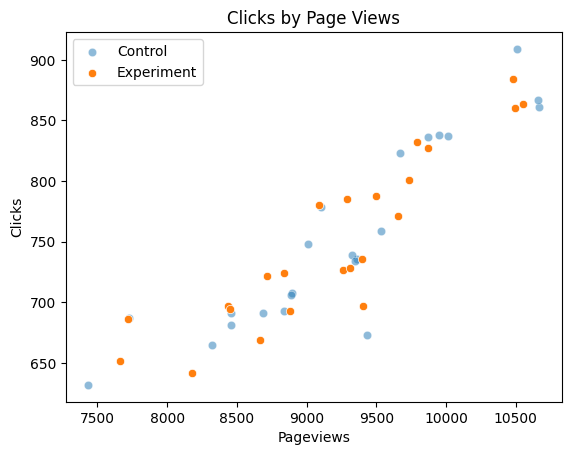

In [503]:
sns.scatterplot(y = df_control['Clicks'],x = df_control['Pageviews'], alpha = 0.5)
sns.scatterplot(y = df_exp['Clicks'],x = df_exp['Pageviews'])
plt.title('Clicks by Page Views')
plt.legend(labels=['Control','Experiment'])
plt.legend(labels=['Control','Experiment']);

* The relationship between page views and clicks is shown by the positive trend

### Enrolments and Payments

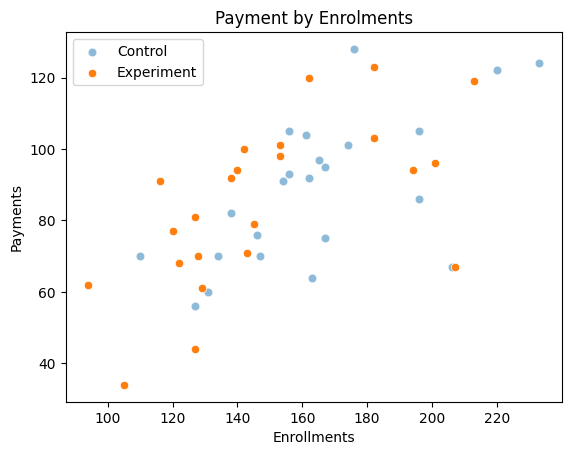

In [839]:
sns.scatterplot(y = df_train["Payments"],x = df_train['Enrollments'], alpha = 0.5)
sns.scatterplot(y = df_exp["Payments"],x = df_exp['Enrollments'])
plt.title('Payment by Enrolments')
plt.legend(labels=['Control','Experiment'])
plt.legend(labels=['Control','Experiment']);

* There appears to be some relationship between enrollments and payments as we would expect but it is not as clear as between clicks and page views interestingly

### Correlations

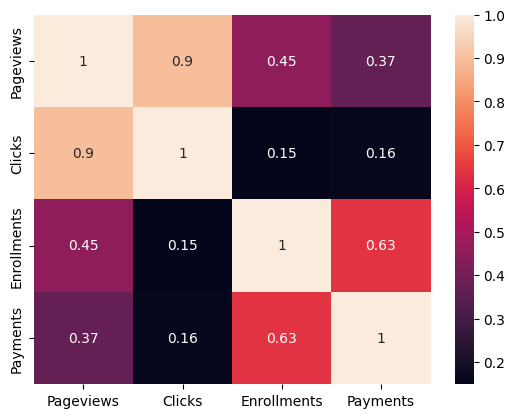

In [840]:
# Correlations between numerical features and enrolments
sns.heatmap(df_train.corr(), annot = True);

* As we would expect payments are highly related to enrolments and clicks to page views
* There is some multi-collinearity in the data
* If we wish our model to be explainable then we need to deal with this as it can undermine the reliability of the coefficients.
* If we are using our model primarily for prediction, then we can be less concerned with multicollinearity in the data

In [507]:
# Add column identifiers to the datasets
df_control["Ind"] = 0
df_exp["Ind"] = 1

In [598]:
# Combine the control and treatment groups
df_combined = pd.concat([df_control, df_exp], axis = 0)
df_combined.reset_index(inplace = True)

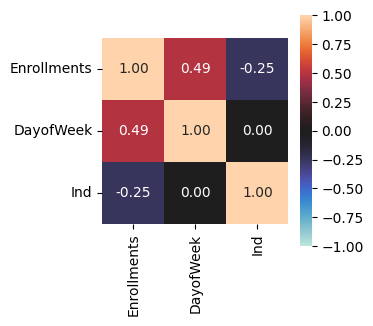

In [831]:
# Relationships between categorical revenue and categorical features
associations(df_combined[['Enrollments','DayofWeek','Ind']], nom_nom_assoc='theil', figsize = (3,3));

In [856]:
# Shuffle the data
df_combined = df_combined.sample(frac = 1)
df_combined.head()

,index,Pageviews,Clicks,Enrollments,Payments,DayofWeek,Ind
0,0,7723,687,134,70,Sat,0
26,3,9867,827,138,92,Tue,1
25,2,10480,884,145,79,Mon,1
39,16,9655,771,213,119,Mon,1
33,10,10551,864,143,71,Tue,1


In [857]:
df_combined.shape

(46, 7)

In [898]:
# Split out X and y from the training and test sets
X = df_combined.drop(columns = ["Payments"], axis = 1)
y = df_combined["Payments"]

In [914]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((36, 6), (10, 6), (36,), (10,))

In [915]:
X_train.head(2)

,index,Pageviews,Clicks,Enrollments,DayofWeek,Ind
16,16,9535,759,233,Mon,0
1,1,9102,779,147,Sun,0


In [916]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
index,36.00,10.72,6.96,0.00,4.75,10.50,17.00,22.00
Pageviews,36.00,9248.78,762.60,7434.00,8836.00,9298.00,9751.00,10667.00
Clicks,36.00,757.14,71.22,632.00,696.50,737.50,824.00,909.00
Enrollments,36.00,157.69,29.47,110.00,137.00,155.00,174.50,233.00
Ind,36.00,0.44,0.50,0.00,0.00,0.00,1.00,1.00


In [917]:
# One hot encode the categorical variable for the training set
cat_train = X_train[["DayofWeek"]]
cat_train = pd.get_dummies(cat_train)
cat_train.columns = ["Fri","Mon","Sat","Sun","Thu","Tue","Wed"]
cat_train.head(2)

,Fri,Mon,Sat,Sun,Thu,Tue,Wed
16,0,1,0,0,0,0,0
1,0,0,0,1,0,0,0


In [918]:
# Do the same for the test set
cat_test = X_test[["DayofWeek"]]
cat_test = pd.get_dummies(cat_test)
cat_test.head(2)

,DayofWeek_Fri,DayofWeek_Mon,DayofWeek_Sat,DayofWeek_Thu,DayofWeek_Tue
19,0,0,0,1,0
37,0,0,1,0,0


In [919]:
# Insert a column for Saturday in the same position as the training set which is missing in the test set
cat_test.insert(5, 'DayofWeek_Wed', 0)
cat_test.insert(3,'DayofWeek_Sun',0)
cat_test.columns = ["Fri","Mon","Sat","Sun","Thu","Tue","Wed"]
cat_test.head(2)

,Fri,Mon,Sat,Sun,Thu,Tue,Wed
19,0,0,0,0,1,0,0
37,0,0,1,0,0,0,0


In [920]:
# Scale numerical features
num_train = X_train[["Pageviews","Clicks","Enrollments"]]
num_test = X_test[["Pageviews","Clicks","Enrollments"]]
scale = StandardScaler()
num_train = pd.DataFrame(scale.fit_transform(num_train))
num_train.columns = ["Pageviews","Clicks","Enrollments"]
num_test = pd.DataFrame(scale.transform(num_test))
num_test.columns = ["Pageviews","Clicks","Enrollments"]

In [921]:
# Concat the training and test data
X_train = pd.concat([num_train.reset_index(drop = True), cat_train.reset_index(drop = True),X_train.Ind.reset_index(drop = True)],axis = 1,ignore_index = True)
X_test = pd.concat([num_test.reset_index(drop = True), cat_test.reset_index(drop = True), X_test.Ind.reset_index(drop = True)],axis = 1)
X_train.columns = ['Pageviews','Clicks','Payments','Fri','Mon','Sat','Sun','Thu','Tue','Wed','Ind']
X_test.columns = ['Pageviews','Clicks','Payments','Fri','Mon','Sat','Sun','Thu','Tue','Wed','Ind']
X_train.head()

,Pageviews,Clicks,Payments,Fri,Mon,Sat,Sun,Thu,Tue,Wed,Ind
0,0.38,0.03,2.59,0,1,0,0,0,0,0,0
1,-0.20,0.31,-0.37,0,0,0,1,0,0,0,0
2,0.10,-0.26,1.32,0,0,0,0,0,0,1,0
3,-0.49,-0.91,-0.16,0,0,0,1,0,0,0,1
4,0.93,1.15,0.15,0,0,0,0,0,0,1,0


In [922]:
X_test.head()

,Pageviews,Clicks,Payments,Fri,Mon,Sat,Sun,Thu,Tue,Wed,Ind
0,0.13,-0.33,0.32,0,0,0,0,1,0,0,0
1,-0.77,-1.26,-1.06,0,0,1,0,0,0,0,1
2,0.25,-1.20,2.14,1,0,0,0,0,0,0,0
3,-1.23,-1.31,-1.06,0,0,0,0,1,0,0,0
4,-2.04,-1.01,-1.81,0,0,1,0,0,0,0,1


## Build Models to Predict Payments

In [925]:
lr = LinearRegression()
rf = RandomForestRegressor()
svm = SVR()

In [927]:
model1 = lr.fit(X_train, y_train)
model2 = rf.fit(X_train, y_train)
model3 = svm.fit(X_train, y_train)

In [930]:
print(model1.score(X_train, y_train))
print(model2.score(X_train, y_train))
print(model3.score(X_train, y_train))

0.5119976620675968
0.8685113661142727
0.011084797918753386


* The random forest model result has the highest coefficient of determination (R-squared) so more than 80% of the points should fall within the regression line. 
* We expect the value to be between 0 and 1
* The support vector regressor value is close to 0, indicating that the regression line represents none of the datapoints.

In [932]:
# Get predictions
y_pred = rf.predict(X_test).astype(int)
y_pred

array([ 90,  68,  97,  65,  73, 104,  88,  92,  73,  86])

In [933]:
y_test = np.array(y_test)
y_test

array([ 75,  81, 122,  56,  34, 123,  71,  98,  62, 119])

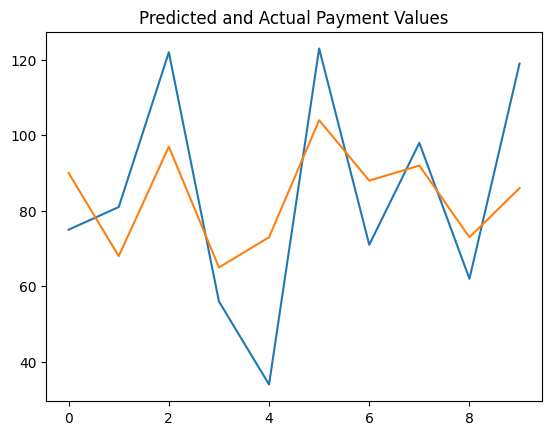

In [943]:
# Plot the results of the prediction against true y values
plt.plot(y_test)
plt.plot(y_pred)
plt.title("Predicted and Actual Payment Values");

In [934]:
# RMSE
np.sqrt(mean_squared_error(y_test, y_pred))

21.253235047869772

In [935]:
# R squared
r2_score = r2_score(y_test, y_pred)
r2_score

0.4630864505699581

In [937]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

* The r2 value on the test set is not as good as for the training set, suggesting we may have overfitted the model
* The dataset is very small so we might expect this
* We would normally try to reduce the depth of tree or the number of variables sampled at each split but there is not much scope to do this as the depth is default at None and the split at 2.
* The model is only able to explain 46% of the variability in payments based on clicks, enrolments, page views and whether or not the user is shown the popup.
* Suggestion - more data